<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.5 MB/s eta 0:00:00


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [6]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for text in tqdm(dataset["train"]["text"]):
    sentences.extend([sentence.lower() for sentence in sent_tokenize(text)
    if len(sentence.split()) < word_threshold])

  0%|          | 0/25000 [00:00<?, ?it/s]

In [7]:
print("Всего предложений:", len(sentences))

Всего предложений: 219930


Посчитаем для каждого слова его встречаемость.

In [8]:
words = Counter()

# Расчет встречаемости слов
for sent in tqdm(sentences):
    for word in word_tokenize(sent):
        words[word] += 1

  0%|          | 0/219930 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

Изменил vocab_size на 30000, потому что иначе ловил cuda out of memory

In [22]:
vocab = set()
vocab_size = 30000

# Наполнение словаря
vocab.add("<unk>")
vocab.add("<bos>")
vocab.add("<eos>")
vocab.add("<pad>")

for word, _ in tqdm(words.most_common(vocab_size)):
    vocab.add(word)

  0%|          | 0/30000 [00:00<?, ?it/s]

In [23]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [24]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 30004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [25]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [26]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = []
        sentence_words = word_tokenize(self.data[idx])

        tokenized_sentence.append(self.bos_id)
        tokenized_sentence = [word2ind.get(x, self.unk_id) for x in sentence_words]
        tokenized_sentence.append(self.eos_id)

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [27]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [28]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [29]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch["input_ids"]).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [34]:
def train_model(model, criterion, optimizer, train_dataloader, test_dataloader, n_epochs):
    model.to(device)
    losses = []
    perplexities = []

    for epoch in range(n_epochs):
        model.train()
        losses_per_epoch = []
        for batch in tqdm(train_dataloader, desc=f"Training epoch {epoch+1}"):
            optimizer.zero_grad()
            logits = model(batch["input_ids"]).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch["target_ids"].flatten(start_dim=0, end_dim=1))
            losses_per_epoch.append(loss.item())
            loss.backward()
            optimizer.step()

        losses.append(sum(losses_per_epoch) / len(losses_per_epoch))
        perplexities.append(evaluate(model, criterion, test_dataloader))

        print(f"loss: {losses[-1]} perplexity: {perplexities[-1]}")

    return losses, perplexities

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

В качестве первого эксперимента попробуем обучить модель с двумя RNN блоками

In [31]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size: int, hidden_dim: int):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True, num_layers=2)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)
        output = self.dropout(self.linear(self.non_lin(output)))
        projection = self.projection(self.non_lin(output))

        return projection

In [35]:
model_1 = LanguageModel(vocab_size=len(vocab), hidden_dim=256)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model_1.parameters())

In [36]:
losses_1, perplexity_1 = train_model(
    model_1, criterion, optimizer, train_dataloader, eval_dataloader, 10
)

Training epoch 1:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 5.213601868716153 perplexity: 114.8799353488656


Training epoch 2:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 4.67107781011408 perplexity: 90.87014983864718


Training epoch 3:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 4.4861970357027925 perplexity: 80.27617879468342


Training epoch 4:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 4.3655732217268515 perplexity: 74.4790252685547


Training epoch 5:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 4.276151328693737 perplexity: 70.05592344860698


Training epoch 6:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 4.2012924938201905 perplexity: 67.35838419892067


Training epoch 7:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 4.141829202131792 perplexity: 66.50583590352258


Training epoch 8:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 4.090327617645264 perplexity: 64.95373890455379


Training epoch 9:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 4.045182149887085 perplexity: 63.97154330985491


Training epoch 10:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 4.003714793118563 perplexity: 61.423722012098445


### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

Теперь попробуем использовать GRU в модели вместо обычных RNN блоков

In [37]:
class LanguageModelGRU(nn.Module):
    def __init__(self, vocab_size: int, hidden_dim: int):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)
        output = self.dropout(self.linear(self.non_lin(output)))
        projection = self.projection(self.non_lin(output))

        return projection

In [38]:
model_2 = LanguageModelGRU(vocab_size=len(vocab), hidden_dim=256)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model_2.parameters())

In [39]:
losses_2, perplexity_2 = train_model(
    model_2, criterion, optimizer, train_dataloader, eval_dataloader, 10
)

Training epoch 1:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 5.195119550531561 perplexity: 109.01260934430499


Training epoch 2:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 4.600246499495073 perplexity: 83.40238656775895


Training epoch 3:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 4.393268453424628 perplexity: 71.62146429461102


Training epoch 4:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 4.2558100008531055 perplexity: 64.6656084859094


Training epoch 5:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 4.1503890297629615 perplexity: 60.2389645620834


Training epoch 6:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 4.063566462256691 perplexity: 56.82524439124174


Training epoch 7:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 3.9889315117922695 perplexity: 54.29396380491035


Training epoch 8:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 3.923493951450695 perplexity: 52.157363705302394


Training epoch 9:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 3.864694218895652 perplexity: 50.451512476455335


Training epoch 10:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 3.81171580470692 perplexity: 49.061023816397025


### Третий эксперимент

Попробуем изменить размер скрытого состояния (за основу возьмем модель с GRU)

In [40]:
model_3 = LanguageModelGRU(vocab_size=len(vocab), hidden_dim=128)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model_3.parameters())

In [41]:
losses_3, perplexity_3 = train_model(
    model_3, criterion, optimizer, train_dataloader, eval_dataloader, 10
)

Training epoch 1:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 5.492602473865856 perplexity: 145.5814270108245


Training epoch 2:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 4.873627959164706 perplexity: 112.42334360965462


Training epoch 3:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 4.690235653270375 perplexity: 97.86755297904791


Training epoch 4:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 4.575771240581165 perplexity: 89.37673389079958


Training epoch 5:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 4.493176484194668 perplexity: 83.6557504432146


Training epoch 6:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 4.42881538772583 perplexity: 79.45244340674822


Training epoch 7:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 4.376406084580855 perplexity: 76.1022008097449


Training epoch 8:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 4.332532369093461 perplexity: 73.53825467131858


Training epoch 9:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 4.294925887714733 perplexity: 71.27934190395267


Training epoch 10:   0%|          | 0/1375 [00:00<?, ?it/s]

loss: 4.260438103068958 perplexity: 69.38240139983421


### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

In [42]:
import pandas as pd

In [57]:
scores = pd.DataFrame({"loss_5_epoch": [losses_1[4], losses_2[4], losses_3[4]],
                       "loss_10_epoch": [losses_1[-1], losses_2[-1], losses_3[-1]],
                       "perplexity_5_epoch": [perplexity_1[4], perplexity_2[4], perplexity_3[4]],
                       "perplexity_10_epoch": [perplexity_1[-1], perplexity_2[-1], perplexity_3[-1]]},
                      index=["model_base", "model_gru", "model_hid-dim"])

scores

,loss_5_epoch,loss_10_epoch,perplexity_5_epoch,perplexity_10_epoch
model_base,4.276151,4.003715,70.055923,61.423722
model_gru,4.150389,3.811716,60.238965,49.061024
model_hid-dim,4.493176,4.260438,83.655750,69.382401


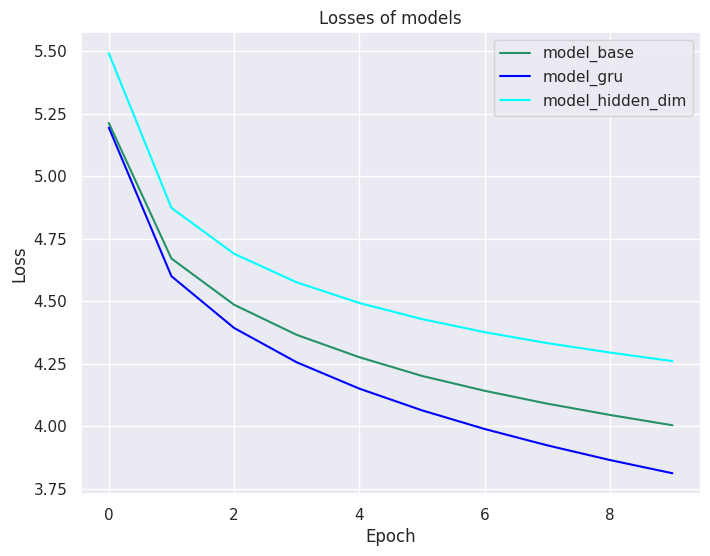

In [55]:
plt.figure(figsize=(8,6))
plt.plot(losses_1, label="model_base")
plt.plot(losses_2, label="model_gru", c="blue")
plt.plot(losses_3, label="model_hidden_dim", c="cyan")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Losses of models")
plt.show()

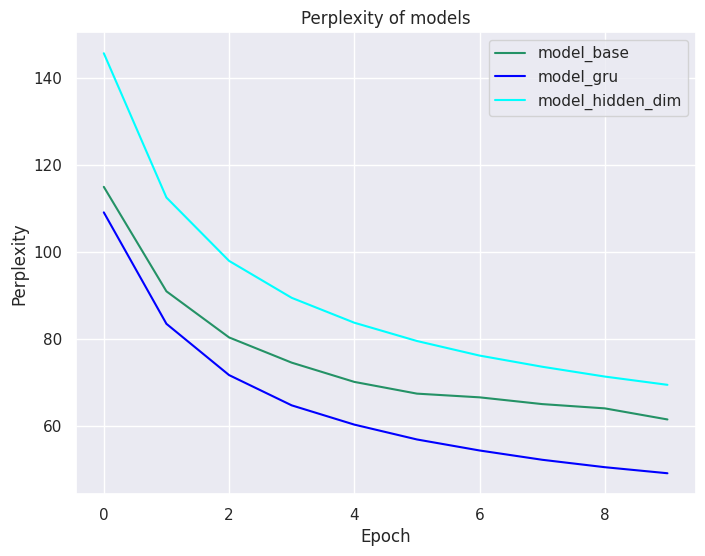

In [56]:
plt.figure(figsize=(8,6))
plt.plot(perplexity_1, label="model_base")
plt.plot(perplexity_2, label="model_gru", c="blue")
plt.plot(perplexity_3, label="model_hidden_dim", c="cyan")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Perplexity of models")
plt.show()

Как мы видим, у всех трех моделей loss и perplexity еще падали, а значит можно было добиться большего качества при увеличении количества эпох

- Лучше качество среди трех показала модель с GRU и hidden_dim=256; использование GRU вместо RNN улучшило заметно качество
- Уменьшение hidden_dim сильно ухудшило результат и показало худшее качество